In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
import time

tf.__version__

'2.8.0'

#  Data preprocessing

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

print(train_data.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [3]:
train_data = train_data / 255.
train_data = train_data.reshape([-1, 28, 28, 1])
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape([-1, 28, 28, 1])
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

label = 5


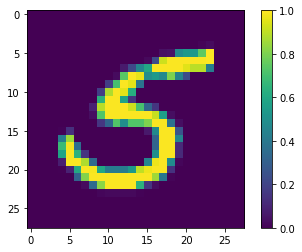

In [4]:
index = 219
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index][...,0])
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [5]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

# Make a dataset

In [6]:
batch_size = 32
max_epochs = 10

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


# Make a model

In [7]:
model = tf.keras.Sequential()

In [8]:
# input shape (32, 28, 28, 1)
model.add(layers.Conv2D(filters=32, kernel_size=[5, 5], padding='same', activation='relu'))
# conv1 shape (32, 28, 28, 32)
model.add(layers.MaxPool2D())
# max pool shape (32, 14, 14, 32)
model.add(layers.Conv2D(filters=64, kernel_size=[5, 5], padding='same', activation='relu'))
model.add(layers.MaxPool2D())
# max pool shape (32, 7, 7, 64)
model.add(layers.Flatten()) # (32, 7*7*64)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [9]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  predictions = model(images[0:1], training=False)
  print("Predictions: ", predictions.numpy())

Predictions:  [[0.1092837  0.08887362 0.09074704 0.10264996 0.10309875 0.10666811
  0.10207342 0.10033645 0.09528255 0.1009864 ]]


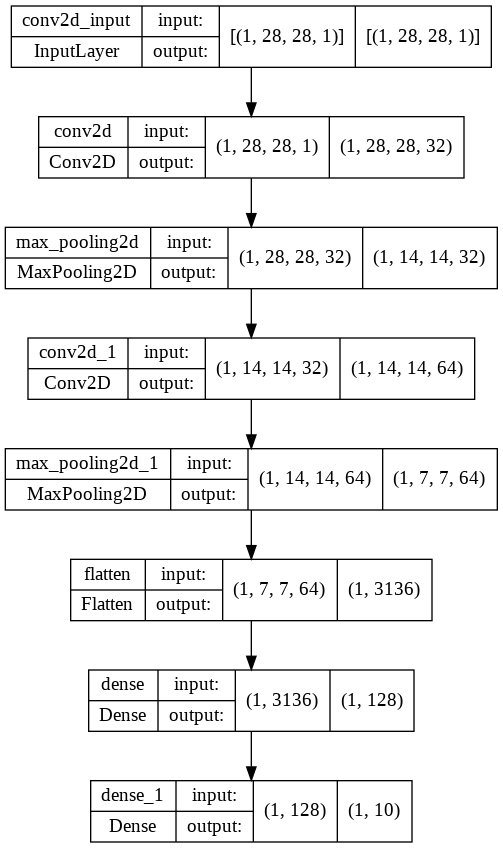

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Training

In [11]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
acc_object = tf.keras.metrics.CategoricalAccuracy()

In [12]:
# use Adam optimizer 
optimizer = tf.keras.optimizers.Adam(1e-4)

# record loss and accuracy for every epoch
mean_loss = tf.keras.metrics.Mean("loss")
mean_accuracy = tf.keras.metrics.Mean("accuracy")

# save loss and accuracy history for plot
loss_history = []
accuracy_history = [(0, 0.0)]

In [13]:
print("start training!")
global_step = tf.Variable(0, trainable=False)
num_batches_per_epoch = int(N / batch_size)

for epoch in range(max_epochs):
  
  for step, (images, labels) in enumerate(train_dataset):
    start_time = time.time()
    
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss_value = loss_object(labels, predictions)
      acc_value = acc_object(labels, predictions)

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    global_step.assign_add(1)
    
    mean_loss(loss_value)
    mean_accuracy(acc_value)
    loss_history.append((global_step.numpy(), mean_loss.result().numpy()))

    if global_step.numpy() % 10 == 0:
      clear_output(wait=True)
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration) 
      print("epochs: {:.2f}, step: {}, loss: {:.3g}, accuracy: {:.4g}% ({:.2f} examples/sec; {:.4f} sec/batch)".format(
          epochs, global_step.numpy(), loss_value.numpy(), acc_value.numpy()*100, examples_per_sec, duration))
      
  # save mean accuracy for plot
  accuracy_history.append((global_step.numpy(), mean_accuracy.result().numpy()))

  # clear the history
  mean_accuracy.reset_states()

print("training done!")

start training!
epochs: 0.00, step: 10, loss: 2.29, accuracy: 18.44% (272.22 examples/sec; 0.1176 sec/batch)
epochs: 0.01, step: 20, loss: 2.14, accuracy: 21.41% (176.72 examples/sec; 0.1811 sec/batch)
epochs: 0.02, step: 30, loss: 2.09, accuracy: 26.25% (163.49 examples/sec; 0.1957 sec/batch)
epochs: 0.02, step: 40, loss: 1.98, accuracy: 32.97% (168.65 examples/sec; 0.1897 sec/batch)
epochs: 0.03, step: 50, loss: 1.75, accuracy: 38.75% (147.35 examples/sec; 0.2172 sec/batch)
epochs: 0.03, step: 60, loss: 1.51, accuracy: 44.01% (157.88 examples/sec; 0.2027 sec/batch)
epochs: 0.04, step: 70, loss: 1.41, accuracy: 48.17% (197.71 examples/sec; 0.1618 sec/batch)
epochs: 0.04, step: 80, loss: 1.1, accuracy: 52.27% (157.16 examples/sec; 0.2036 sec/batch)
epochs: 0.05, step: 90, loss: 0.94, accuracy: 54.83% (120.25 examples/sec; 0.2661 sec/batch)
epochs: 0.05, step: 100, loss: 0.856, accuracy: 57.19% (150.36 examples/sec; 0.2128 sec/batch)
epochs: 0.06, step: 110, loss: 0.733, accuracy: 59.09

# History

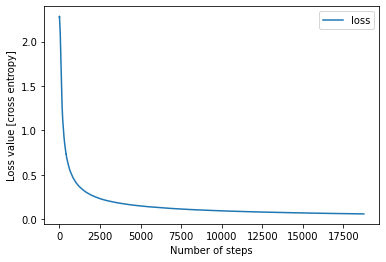

In [14]:
plt.plot(*zip(*loss_history), label='loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

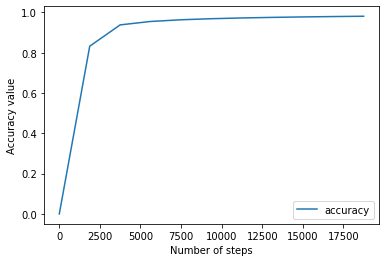

In [15]:
plt.plot(*zip(*accuracy_history), label='accuracy')
plt.xlabel('Number of steps')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

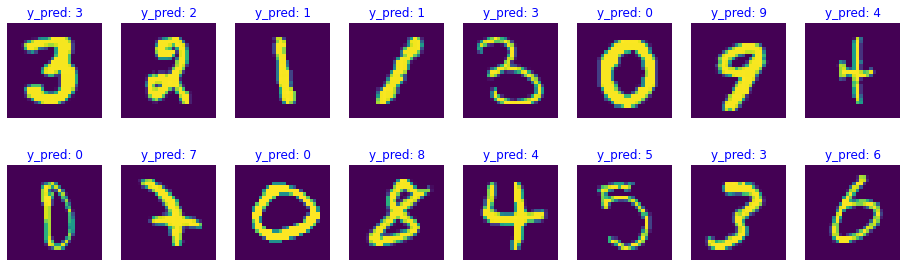

In [16]:
np.random.seed(219)
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')